In [140]:
using NGSIM
using AutomotiveDrivingModels
using AutoViz
using Interact # Make video in notebook
using Reel # Save video as gif
using CSV # For writing to csv
using DataFrames # For writing to csv
using Distributions
using Test
using StatsBase
using Dates
using Plots
using JLD
using DelimitedFiles # To write to text file

In [50]:
include("admin_functions.jl"); # Brings in the functions defined in admin_functions.jl

In [88]:
traj_ngsim = open(io->read(io, MIME"text/plain"(), Trajdata), 
    "trajdata_i101_trajectories-0750am-0805am.txt", "r");
roadway_ngsim = open(io->read(io, MIME"text/plain"(), Roadway), 
    "ngsim_101.txt", "r");

# Utils

In [116]:
"""
    function sample_init_particles(num_p::Int64;v=30.0)

Inspired from `gen_test_particles` in `admin.jl`.
Samples `num_p` particles neighbourhood around the input `v`

# Used by
- `multistep_update`

# Example
```julia
sample_init_particles(10,v=20.0)
```
"""
function sample_init_particles(num_p::Int64;v::Float64=30.0)
    v_particles = sample(v-5.0:0.5:v+5.0,num_p)
    sig_particles = sample(1.0:0.1:5.0,num_p)
    p_set_dict = Dict(:v_des=>v_particles,:σ=>sig_particles)
    return p_set_dict
end

"""
    function get_ngsim_scene(framenum::Int64)

Get a specific scene from traj_ngsim

# Used by
- `multistep_update`

# Example:
```julia
scene = get_ngsim_scene(1)
```
"""
function get_ngsim_scene(framenum::Int64)
    scene = Scene(500)
    get!(scene,traj_ngsim,framenum)
    return scene
end

"""
    function get_veh_info(scene;car_id = -1)

Get position and velocity of specific vehicle from scene

# Used by
- `multistep_update`

# Example
```julia
scene = get_highd_scene(7)
pos,vel = get_veh_info(scene,car_id = 6)
@show pos,vel
```
"""
function get_veh_info(scene;car_id = -1)
    @assert car_id>0
    pos = scene.entities[findfirst(car_id,scene)].state.posF.s
    vel = scene.entities[findfirst(car_id,scene)].state.v
    return pos,vel
end

"""
    function keep_vehicle_subset!(scene::Scene, ids::Vector{Int})
Will come in useful to remove those vehicles from video who we do not learn filter for.
Obtained from `ngsim_env/julia/src/ngsim_utils.jl`

# Arguments
- `ids` List of integers with ids of vehicles to be kept
- `scene` A scene in which to keep vehicles given in `ids` and remove the rest of the vehicles

# Used by
- `run_simulation` Only keep those vehicles in the scene for which we have done filtering

# Example
```julia
scene = Scene(500)
get!(scene,traj_ngsim,300)
keep_vehicle_subset!(scene,veh_id_list)
```
"""
function keep_vehicle_subset!(scene::Scene, ids::Vector{Int})
    keep_ids = Set(ids)
    scene_ids = Set([veh.id for veh in scene])
    remove_ids = setdiff(scene_ids, keep_ids)
    for id in remove_ids
        delete!(scene, id)
    end
    return scene
end

"""
    function avg_dist_particles(p_mat,p_fin)
Compute the avg distance over particle set from final particle

# Arguments
- `p_mat`: Matrix with particles in every column
- `p_fin`: 2x1 array with the final particle

# Example:
- See `obtain_driver_models`
"""
function avg_dist_particles(p_mat,p_fin)
    return sum(sqrt.(sum((p_mat .- p_fin).^2,dims=1)))*1/size(p_mat,2)
end

"""
    function addnoise
Add noise to elite particles to counter the particle deprivation problem
- Used by `multistep_update`
# Arguments
- `p_set_mat`: Matrix with each column being a particle. Row1 has `v_des` and row2 has `sigma`
- `weight_vec`: Associated weight for particles. To capture the elite 20% for noise addition 

# Returns
- `new_set` Set of particles with noise added

# Example
See `multistep_update`
```julia
num_p = 10
v = 30.
v_particles = rand(v-5.0:0.5:v+5.0,1,num_p)
sig_particles = rand(0.1:0.1:3.0,1,num_p)
p_set = [v_particles;sig_particles]
@show p_set
scatter(p_set[1,:],p_set[2,:],xlim=(22,36),ylim=(0,4),leg=false,markercolor = "red")
new_p = addnoise(p_set)
@show new_p
scatter!(new_p[1,:],new_p[2,:],xlim=(22,36),ylim=(0,4),leg=false,markercolor="green")
```
"""
function addnoise(p_set_mat,weight_vec)
    # Select the elite particles
    num_p = size(p_set_mat,2)
    num_top = Int(ceil(0.2*num_p))
    
    sorted_idx = sortperm(weight_vec,rev=true)[1:num_top] 
    
    # Generate permuter for v_des and sigma
    v_noise = rand([-0.5,0.,0.5],1,num_top)
    sig_noise = rand([-0.1,0.,0.1],1,num_top)
    stacked_noise = [v_noise;sig_noise]
    
    # Add noise only to the elite particles i.e top 20% particles
    p_set_mat[:,sorted_idx] = p_set_mat[:,sorted_idx] + stacked_noise
    new_set = p_set_mat
    
    # Impose bounds to avoid sigma becoming 0
    new_set[2,findall(new_set[2,:] .< 0.1)] .= 0.1
    return new_set
end

addnoise

In [117]:
"""

# Caution
- `dt` defined within the function. Here is 0.1, highd had 0.04

# Example
```julia
td1 = load_trajdata(1);
scene = Scene(500)
get!(scene,td1,300)
display(scene.entities[2].state.posF.s)
roadway = ROADWAY_101;
particle = Dict(:v_des=>25.0,:σ=>0.5)
hallucinate_a_step(roadway,scene,particle,car_id=scene.entities[2].id)
```
"""
function hallucinate_a_step(roadway,scene_input,particle;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    
    scene = deepcopy(scene_input)
    #scene = scene_input # This was the failure case
    n_cars = scene.n 

    models = Dict{Int, DriverModel}()
    
    # Create driver models for all the cars in the scene
    for veh in scene
        if veh.id == car_id
            models[veh.id] = IntelligentDriverModel(;particle...)
        else
            # TODO: RESEARCH QUESTION: What drives the other vehicles in the hallucination
            models[veh.id] = IntelligentDriverModel(v_des=10.0)
        end
    end
    
    n_steps = 1
    dt = 0.1
    rec = SceneRecord(n_steps, dt)
    
    simulate!(rec, scene, roadway, models, n_steps)
    
    X = Array{Float64}(undef,n_steps, 1)

    for t in 1:n_steps
        f = rec.frames[n_steps - t + 1]
        
            # Access the vehicle with id as car_id and return its frenet s
        X[t,1] = scene.entities[findfirst(car_id,f)].state.posF.s
    end
    return X[1]
end

"""

# Caution
- `timestep` defined in the function. Was 0.04 for highd. Here is 0.1
"""
function compute_particle_likelihoods(roadway,f,trupos,p_set_dict;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    timestep = 0.1 #TODO: Remove hardcoding
    p_mat, params, vec_val_vec = to_matrix_form(p_set_dict)
    
    num_params=size(p_mat)[1]
    num_p = size(p_mat)[2]
    lkhd_vec = Array{Float64}(undef,num_p)
    for i in 1:num_p    
        # Create dict version for a single particle
        p_dict = Dict()
        for j in 1:num_params
            p_dict[params[j]]=vec_val_vec[j][i]
        end
        
        std_dev_acc = p_dict[:σ]
        
        # hack to avoid the std_dev_pos become negative and error Normal distb
        if std_dev_acc <= 0 std_dev_acc = 0.1 end
        
        # TODO: This math needs to be verified from random variable calculations
        std_dev_pos = timestep*timestep*std_dev_acc
            
        hpos = hallucinate_a_step(roadway,f,p_dict,car_id=car_id)
        lkhd_vec[i] = pdf(Normal(hpos,std_dev_pos),trupos[1])
    end
    return lkhd_vec,p_mat,params
end

"""
    function update_p_one_step(roadway,f,trupos,p_set_dict;car_id=-1)
New particle set based on one step of resampling

# Returns
- `new_p_set_dict`: Dictionary with keys as parameters and values as array of particles
- `p_weight_vec`: Vector with weights associated to the particles in `new_p_set_dict`
"""
function update_p_one_step(roadway,f,trupos,p_set_dict;car_id=-1)
    if car_id==-1 @show "Provide valid car_id" end
    
    lkhd_vec,p_mat,params = compute_particle_likelihoods(roadway,f,trupos,p_set_dict,
                                                        car_id=car_id)
    
    num_params = size(p_mat)[1]
    num_p = size(p_mat)[2]

    ll_vec = log.(lkhd_vec)
    
    # TODO: This is hacky. What if log is not negative
    for i in 1:num_p
        if isinf(ll_vec[i])
            ll_vec[i] = 0
        else
            ll_vec[i] = -1*1/ll_vec[i]
        end
    end
    
    p_weight_vec = weights(ll_vec./sum(ll_vec)) # Convert to weights form to use julia sampling
    idx = sample(1:num_p,p_weight_vec,num_p)
    new_p_mat = p_mat[:,idx] #Careful that idx is (size,1) and not (size,2)
    
    new_p_set_dict = to_dict_form(params,new_p_mat)
    return new_p_set_dict, p_weight_vec
end

update_p_one_step

In [90]:
"""
    function plot_particles(p_set_mat::Array{Float64,2},time::Float64)

Plot the distribution of particles
# Caution 
Only work for 2 parameters. Not developed for 3 parameter case yet

# Used by
- `multistep_update`

# Example:
```julia
set_for_plotting = to_particleMatrix(p_set_new)
plots = []
push!(plots,plot_particles(set_for_plotting,framenum*0.04))
```
"""
function plot_particles(p_set_mat::Array{Float64,2},time::Float64)
    # Check that number of params does not exceed 3
    
    @assert size(p_set_mat,1) <= 3
    plt = Plots.plot()
    # 2 parameter case	
    if size(p_set_mat,1) == 2
        plt = scatter(p_set_mat[1,:],p_set_mat[2,:],
            leg=false,title="time=$(time)",xlim=(25,35),ylim=(0,1.2),
                xlabel="v_des(m/s)",ylabel="sigma")

    # 3 parameter case
    else
        plt = scatter(p_set_mat[1,:],p_set_mat[2,:],p_set_mat[3,:],leg=false)
        scatter!([true_params[1]],[true_params[2]],[true_params[3]])
    end
    return plt
end

plot_particles

In [44]:
"""
    function make_gif(plots;filename="output.mp4")
Make a video using an array of plots. Uses the Reel library

# Used by
- `multistep_update`
"""
function make_gif(plots;filename="output.mp4")
@assert typeof(filename) == String
#@show "Making gif"
    frames = Frames(MIME("image/png"), fps=10)
    for plt in plots
        push!(frames, plt)
    end
    write(string("media/",filename), frames)
    return nothing
end # End of the reel gif writing function

"""
    my_overlay
Overlaying hallucinated trajectory on the ground truth
# Fields
- `color::Colorant`
- `scene::Scene`
"""
# Borrowed from visualization_functions.jl
struct my_overlay <: SceneOverlay
    scene::Scene
    color # Needs to be of form colorant"Colorname"
end

function AutoViz.render!(rendermodel::RenderModel,overlay::my_overlay, 
        scene::Scene, roadway::Roadway)
    AutoViz.render!(rendermodel,overlay.scene,car_color = overlay.color)
    return rendermodel
end

"""
    IDOverlay
Display the ID on top of each entity in a scene.
# Fields
- `color::Colorant`
- `font_size::Int64`
"""
mutable struct IDOverlay <: SceneOverlay
    color::Colorant
    font_size::Int
end

function AutoViz.render!(rendermodel::RenderModel, overlay::IDOverlay, scene::Scene, 
                            env::E) where E
    font_size = overlay.font_size
    for veh in scene
        add_instruction!(rendermodel, render_text, ("$(veh.id)", veh.state.posG.x, 
                        veh.state.posG.y, font_size, overlay.color), incameraframe=true)
    end
    return rendermodel
end

"""
    function make_video(;range=nothing,filename="output.mp4")

Makes a video of the ngsim dataset on the ngsim roadway taking frame range as input

# Overlays
- Id number of all vehicles
- Timestep as a text overlay

# Example 
```julia
make_video(range=11:60,filename="ngsim_11to60.mp4")
```
"""
function make_video(;range=nothing,filename="ngsim_$(range).mp4")

    frames = Frames(MIME("image/png"), fps=5)
    scene = Scene(500)
    step = 0
    for i in range
        step= step+1
        temp_scene = get!(scene,traj_ngsim,i)
        
        carcolors = Dict{Int,Colorant}()
        for veh in temp_scene
            # Color cars green when they are in segment 3
            if veh.state.posF.roadind.tag.segment == 3
                carcolors[veh.id] = colorant"green"
            end
        end
        
        scene_visual = render(temp_scene, roadway_ngsim, 
            [IDOverlay(colorant"white",10),TextOverlay(text=["step=$(step)"],font_size=12)],
            cam=CarFollowCamera{Int}(51,2.0),
            #cam=StaticCamera(VecE2(1966600, 570750), 1.4),
            #cam=FitToContentCamera(-0.6),
            car_colors = carcolors
        )
        push!(frames,scene_visual)
    end
    write(string("media/"*filename),frames)    
    
    return nothing
end

"""
    function make_vid_truth_halluc(start_frame,last_frame,rec;filename="output.mp4",ids_to_keep = [])
Video with hallucination overlayed over ground truth trajectory

# Arguments
- `start_frame` Frame number to start from
- `last_frame` Frame number to end at
- `rec` SceneRecord which contains hallucinated trajectory
- `ids_to_keep` Id not empty list, vehicles in this list will be the only ones in the scene

# Overlays used
- `my_overlay` To allow overlaying of hallucination on top of ground truth
- `IDOverlay` Overlays the vehicle ids on the video

# Possible breakages
- `traj_highd` We will need to provide this maybe as a global variable
- `roadway_highd` Same. We need global variable

# Example
```julia
make_vid_truth_halluc(300,375,rec_multimodel,filename="ngsim_halluc.mp4",ids_to_keep = veh_id_list)
```
"""
function make_vid_truth_halluc(start_frame,last_frame,rec;filename="output.mp4",ids_to_keep = [])
print("Making video. Filename = $(filename)\n")
    frames = Frames(MIME("image/png"), fps=10)
    scene = Scene(500)

    step = 0
    for i in start_frame:last_frame
        step = step+1
        @show step
        
        true_scene = get!(scene,traj_ngsim,i)
        if !isempty(ids_to_keep)
            keep_vehicle_subset!(true_scene,ids_to_keep)
        end
        
        halluc_scene = rec[i-last_frame]
        if !isempty(ids_to_keep)
            keep_vehicle_subset!(halluc_scene,ids_to_keep)
        end
        
        overlay_truth = my_overlay(true_scene,colorant"white")
        #overlay_hallucination = my_overlay(rec[i-last_frame],colorant"white")

            # Make the ground truth vehicles white
        halluc_colors = Dict{Int64,Colorant}()
        for veh in halluc_scene
            halluc_colors[veh.id] = colorant"blue"
        end
        
        
        scene_visual = render(halluc_scene, roadway_ngsim,
            [overlay_truth,
                IDOverlay(colorant"white",12),
                NeighborsOverlay(55), # To make the features rays
                #NeighborsOverlay(57),
                TextOverlay(text=["step=$step"],font_size = 14)
                ],
            car_colors = halluc_colors,
            #cam=CarFollowCamera{Int}(2,5.0),
            #cam=StaticCamera(VecE2(1966400, 570900), 5.0),
            cam=FitToContentCamera(-1.5))
        push!(frames,scene_visual)
        
    end
    write(string("media/"*filename),frames)
    return nothing
end

"""
    function make_vid_truth_gail_idm
Make a video with ground truth, gail driven and idm driver cars all in one

# Example
```julia
make_vid_truth_gail_idm(300,400,env_rec,rec_multimodels,filename="all3.mp4",ids_to_keep = veh_id_list)
```
"""
function make_vid_truth_gail_idm(start_frame,last_frame,gail_rec,idm_rec;filename="output.mp4",ids_to_keep = [])
    frames = Frames(MIME("image/png"), fps=7)
    scene = Scene(500)

    step = 0
    for i in start_frame:last_frame
        step = step+1
        true_scene = get!(scene,traj_ngsim,i)
        if !isempty(ids_to_keep)
            keep_vehicle_subset!(true_scene,ids_to_keep)
        end
        
        gail_scene = gail_rec[i-last_frame]
        if !isempty(ids_to_keep)
            keep_vehicle_subset!(gail_scene,ids_to_keep)
        end
        
        idm_scene = idm_rec[i-last_frame]
        if !isempty(ids_to_keep)
            keep_vehicle_subset!(idm_scene,ids_to_keep)
        end
        
        gail_overlay = my_overlay(gail_scene,colorant"blue")
        idm_overlay = my_overlay(idm_scene,colorant"yellow")
        
            # Make the ground truth vehicles white
        ground_truth_colors = Dict{Int64,Colorant}()
        for veh in true_scene
            ground_truth_colors[veh.id] = colorant"white"
        end
        
        scene_visual = render(true_scene, roadway_ngsim, car_colors=ground_truth_colors,
            [gail_overlay,idm_overlay,IDOverlay(colorant"white",12),
                TextOverlay(text=["step=$step"],font_size = 14)],
            #cam=CarFollowCamera{Int}(2,5.0),
            #cam=StaticCamera(VecE2(1966400, 570900), 5.0),
            cam=FitToContentCamera(-1.5))
        push!(frames,scene_visual)
        
    end
    write(string("media/"*filename),frames)
    return nothing
end

make_gif

In [118]:
"""
    function multistep_update(num_p::Int64,car_id::Int64,
        start_frame::Int64,last_frame::Int64;p_dist_vid=false)

Returns the mean particle after running multiple steps of filtering

# Arguments
- `start_frame`: Frame to start filtering from
- `last_frame`: Frame to end filtering at
- `num_p`: Number of particles

# Keyworded arguments
- `p_dist_vid`: Default false. Makes a video of particle distribution if true

# Returns
- `mean_particle`: Dict containing the mean values of the final particle set after filtering
- `iterwise_p_set`: List with particle set at each iteration

# Example
```julia
# Make a video for particle evolution for vehicle 13 over 500 steps starting from
# frame 11 and ending at frame number 60
multistep_update(500,13,11,60,p_dist_vid=true)
```
"""
function multistep_update(num_p::Int64,car_id::Int64,
        start_frame::Int64,last_frame::Int64;p_dist_vid=false)

    startscene = get_ngsim_scene(start_frame)
    startpos,startvel = get_veh_info(startscene,car_id=car_id)

    p_set_dict = sample_init_particles(num_p,v=startvel)
    
    plots = []
    init_p_mat = to_particleMatrix(p_set_dict)
    push!(plots,plot_particles(init_p_mat,0.0))
    
    dt = 0.1 # Multiplies framenum in creating the plot

    iterwise_p_set = [] # Stores particle set at every iteration
    push!(iterwise_p_set,init_p_mat)
    
    for framenum in start_frame:last_frame
        #print("multistep says. Framenum = $(framenum)\n")
        scene = get_ngsim_scene(framenum+1)
        trupos,truvel = get_veh_info(scene,car_id=car_id)
        
        # Get the scene to start hallucinating from
        scene = get_ngsim_scene(framenum)
        p_set_new, weight_vec = update_p_one_step(roadway_ngsim,scene,trupos,p_set_dict,car_id=car_id)
        #p_set_dict = p_set_new
        
            # We need a matrix form to be able to add noise
            # Then we need to convert that back to the dict form at the end
        params = [:v_des,:σ]
        p_set_dict = to_dict_form(params,addnoise(to_particleMatrix(p_set_new),weight_vec))
        
        #set_for_plotting = to_particleMatrix(p_set_new) # Matrix form of particle dict
        
            # With noise addition
        set_for_plotting = to_particleMatrix(p_set_dict)
        push!(plots,plot_particles(set_for_plotting,framenum*dt))
        push!(iterwise_p_set,set_for_plotting)
    end

        # Find the mean particle after filtering is over
        # Defined in `admin.jl`
    mean_particle = find_mean_particle(p_set_dict)

        # Make a plot of the particle distribution evolution
    if p_dist_vid 
        print("Making a particle distribution video")
        date = Dates.now()
        make_gif(plots,filename = "vehid_$(car_id)_$(date).gif") 
    end
    
    return mean_particle,iterwise_p_set
end

"""
    function obtain_driver_models(veh_id_list,num_particles,start_frame,last_frame)
Driver models for each vehicle in veh_id_list

# Arguments
- `veh_id_list` List with vehicle ids
- `start_frame` Frame to start filtering from
- `last_frame` Frame to end hallucination at

# Returns
- `models` Dict with veh id as key and IDM driver model as value
- `final_particles` Dict with veh id as key and avg particle over final particle set as value
- `mean_dist_mat`: Every elem is the mean dist of particle set at that iter (row) for that car (column)

# Example
```julia
veh_id_list = [72,75,73,67,69,71,64,59,56,57,62,60,54,55,49,51,48,43,47,39,37,34,44,33,31]
model_multimodels,particles_multimodels = obtain_driver_models(veh_id_list,500,300,375)
```
"""
function obtain_driver_models(veh_id_list,num_particles,start_frame,last_frame)
    models = Dict{Int64,DriverModel}() # key is vehicle id, value is driver model
    final_particles = Dict{Int64,Dict}() # key is vehicle id, value is final particles
    
        # Loop over all the cars and get their corresponding IDM parameters by particle filter
    num_cars = length(veh_id_list)
    num_iters = last_frame-start_frame+2 # NEED TO CONFIRM THIS
    
        # num_iters x num_cars. Every elem is the mean dist of particle set at that iter for that car
    mean_dist_mat = fill(0.,num_iters,num_cars)
    
    for (ii,veh_id) in enumerate(veh_id_list)
        print("obtain_driver_model says: vehicle id = $(veh_id)\n")
        mean_particle, iterwise_p_set = multistep_update(num_particles,veh_id,start_frame,last_frame)
        final_particles[veh_id] = mean_particle
        models[veh_id] = IntelligentDriverModel(;mean_particle...)
        
            # Get the mean distance from final particle over iterations
        p_fin = fill(0.,2,1)
        i = 0
        for (k,v) in mean_particle
            i = i+1
            p_fin[i] = v
        end
        
        # num_iters = length(iterwise_p_set) # SHOULD MATCH OUTSIDE LOOP VARIABLE
        mean_dist_over_iters = fill(0.,num_iters,1)
        for (jj,p_mat) in enumerate(iterwise_p_set)
            mean_dist_over_iters[jj,1] = avg_dist_particles(p_mat,p_fin)
        end
        
        mean_dist_mat[:,ii] = mean_dist_over_iters    
    end
    
        # Average over the cars and plot the filtering progress over frames
    #avg_over_cars = mean(mean_dist_mat,dims=2)
    #plot(avg_over_cars)
    
    return models,final_particles, mean_dist_mat
end

multistep_update

In [47]:
"""
    function run_simulation(n_steps,models,start_frame,dt=0.1;ids_to_keep = [])
Run a simulation using driver models for specified number of timesteps

# Arguments
- `n_steps` Number of simulation steps
- `start_frame` Frame number to start hallucination from
- `models` Dictionary with veh id as key and corresponding driver model as value
- `dt` Timestep (default 0.1 for the ngsim dataset)
- `ids_to_keep` If not empty, then only vehicles present in `ids_to_keep` are retained

# Returns
- `rec` Scenerecord which contains the simulation result i.e. frames. CAUTION: Index backward

# Possible breakage
- `roadway_ngsim` is not passed in as an argument. Will need to make it global
- `model_1` hard coded here for the 50 step case starting from frame 10

# Example
```julia
rec = run_simulation(75,models,299,ids_to_keep = veh_id_list)
```
"""
function run_simulation(n_steps,models,start_frame,dt=0.1;ids_to_keep = [])
    scene = Scene(500)
    get!(scene,traj_ngsim,start_frame)
    
    if !isempty(ids_to_keep)
        keep_vehicle_subset!(scene,ids_to_keep)
    end

    rec = SceneRecord(n_steps,dt)
    simulate!(rec,scene,roadway_ngsim,models,n_steps)
    return rec
end

run_simulation

# Workspace

In [96]:
veh_id_list = [72,75,73,67,69,71,64,59,56,57,62,60,54,55,51,48,43,47,39,37,34,33]
    # Let's debug the bounds error issue
# veh_id_list = [31,44,49]
model_multimodels,particles_multimodels = obtain_driver_models(veh_id_list,500,300,375)

obtain_driver_model says: vehicle id = 72
obtain_driver_model says: vehicle id = 75
obtain_driver_model says: vehicle id = 73
obtain_driver_model says: vehicle id = 67
obtain_driver_model says: vehicle id = 69
obtain_driver_model says: vehicle id = 71
obtain_driver_model says: vehicle id = 64
obtain_driver_model says: vehicle id = 59
obtain_driver_model says: vehicle id = 56
obtain_driver_model says: vehicle id = 57
obtain_driver_model says: vehicle id = 62
obtain_driver_model says: vehicle id = 60
obtain_driver_model says: vehicle id = 54
obtain_driver_model says: vehicle id = 55
obtain_driver_model says: vehicle id = 51
obtain_driver_model says: vehicle id = 48
obtain_driver_model says: vehicle id = 43
obtain_driver_model says: vehicle id = 47
obtain_driver_model says: vehicle id = 39
obtain_driver_model says: vehicle id = 37
obtain_driver_model says: vehicle id = 34
obtain_driver_model says: vehicle id = 33


(Dict{Int64,DriverModel}(54=>IntelligentDriverModel(NaN, 0.9, 1.0, 4.0, 1.5, 14.7153, 5.0, 3.0, 2.0, 9.0),47=>IntelligentDriverModel(NaN, 0.9, 1.0, 4.0, 1.5, 11.5639, 5.0, 3.0, 2.0, 9.0),69=>IntelligentDriverModel(NaN, 0.8, 1.0, 4.0, 1.5, 10.5268, 5.0, 3.0, 2.0, 9.0),62=>IntelligentDriverModel(NaN, 0.8, 1.0, 4.0, 1.5, 14.7603, 5.0, 3.0, 2.0, 9.0),39=>IntelligentDriverModel(NaN, 1.0, 1.0, 4.0, 1.5, 15.1108, 5.0, 3.0, 2.0, 9.0),43=>IntelligentDriverModel(NaN, 1.0, 1.0, 4.0, 1.5, 20.6009, 5.0, 3.0, 2.0, 9.0),75=>IntelligentDriverModel(NaN, 0.4, 1.0, 4.0, 1.5, 14.6103, 5.0, 3.0, 2.0, 9.0),60=>IntelligentDriverModel(NaN, 1.0, 1.0, 4.0, 1.5, 13.4631, 5.0, 3.0, 2.0, 9.0),55=>IntelligentDriverModel(NaN, 1.0, 1.0, 4.0, 1.5, 13.1242, 5.0, 3.0, 2.0, 9.0),34=>IntelligentDriverModel(NaN, 0.7, 1.0, 4.0, 1.5, 17.2607, 5.0, 3.0, 2.0, 9.0)…), Dict{Int64,Dict}(54=>Dict{Any,Any}(:v_des=>14.7153,:σ=>0.9),47=>Dict{Any,Any}(:v_des=>11.5639,:σ=>0.9),69=>Dict{Any,Any}(:v_des=>10.5268,:σ=>0.8),62=>Dict{Any,Any

In [ ]:
# Save the learned models in a jld file to avoid the training process in future
save("idm_models.jld",)

In [98]:
rec_multimodels = run_simulation(100,model_multimodels,299,ids_to_keep=veh_id_list)

SceneRecord(nscenes=100)

In [145]:
make_vid_truth_halluc(301,400,rec_multimodels,filename="ngsim_halluc.mp4",ids_to_keep = veh_id_list)

MethodError: MethodError: no method matching getindex(::Frame{Entity{VehicleState,VehicleDef,Int64}}, ::Nothing)
Closest candidates are:
  getindex(::Frame, !Matched::Int64) at /home/raunak/.julia/packages/Records/q2nsF/src/frames.jl:20

# Scripts

In [ ]:
# Just make a video of replay trajectories. Saves video to media folder
make_video(range=300:400)

In [ ]:
# Load gail driven scenerecord from jld and overlay on top of ground truth
rec_gail = JLD.load("gail_rec.jld","env_rec")
veh_id_list = [72,75,73,67,69,71,64,59,56,57,62,60,54,55,51,48,43,47,39,37,34,33]
make_vid_truth_halluc(301,400,rec_gail,
    filename = "gail_halluc_removed.mp4",ids_to_keep = veh_id_list)

In [75]:
# Barrier with gail
rec_barrier = JLD.load("barrier_rec.jld","env_rec")
veh_id_list = [72,75,73,67,69,71,64,59,56,57,62,60,54,55,51,48,43,47,39,37,34,33]
make_vid_truth_halluc(301,400,rec_barrier,filename = "gail_barrier_id39_id51_new.mp4",
    ids_to_keep = veh_id_list)

In [76]:
# The idea of a barrier. Select some of the vehicles to be driven by IDM with v_des =0
# In this case, vehicle ids 39 and 51. Drive the rest of the vehicles in the list
# using driver models (gail/pf learned idm)
model_multimodels[39].v_des = 0.
model_multimodels[39].σ = 0.
model_multimodels[51].v_des = 0.
model_multimodels[39].σ = 0.
rec_multimodels = run_simulation(100,model_multimodels,299,ids_to_keep=veh_id_list)
make_vid_truth_gail_idm(301,400,rec_barrier,rec_multimodels,
    filename="gail_pf_barrier.mp4",ids_to_keep = veh_id_list)

# for paper

In [ ]:
    # Perform filtering
veh_id_list = [72,75,73,67,69,71,64,59,56,57,62,60,54,55,51,48,43,47,39,37,34,33]
test_model,test_particle,mean_dist_mat_all = obtain_driver_models(veh_id_list,500,300,375)

    # Save to csv
avg_val = mean(mean_dist_mat_all,dims=2)
CSV.write("media/for_icra/pf_prog.csv",  DataFrame(avg_val), writeheader=false)

    # Make a plot
plot(mean(mean_dist_mat_all,dims=2),leg=false,xlabel="iteration number",ylabel="mean distance from final particle",
title="Particle filtering progress")
savefig("media/for_icra/pf_progress.png")

# Playground

In [171]:
avgovercars_gail_rmse_pos = mean(gail_rmse_pos,dims=2)
avgovercars_gail_rmse_vel = mean(gail_rmse_vel,dims=2)

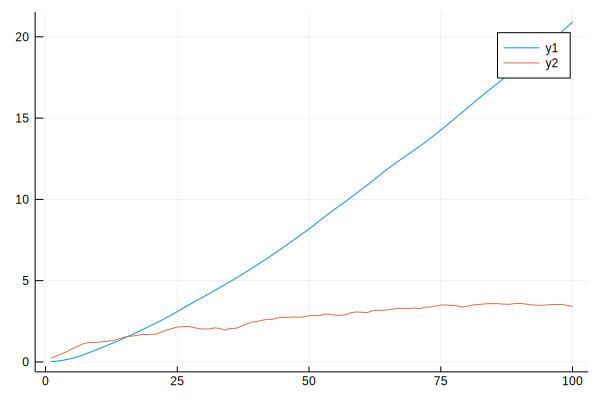

In [173]:
plot(avgovercars_gail_rmse_pos)
plot!(avgovercars_gail_rmse_vel)